<a href="https://colab.research.google.com/github/mojtaba-eshghie/egraphs-for-sc/blob/main/egraphs_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro to EGraphs
----------------

Normally when you have an IR, each node has exactly one definition for a value:

```
t = a * 2
r = t / 2
```
What if we allow the IR to define _multiple_ ways to compute a value?

```
t = {a * 2, a << 1} # two equivalent ways to compute t
r = {t / 2}
```

E-graphs (e for equivalence) are a way of doing this while efficiently detecting places in the IR where identitcal expressions can be merged into equivlance class.


Why would you want to do this? In normal IR, any time you have a rewrite rule (e.g. replace a dvision by 2 with a shift), you have to decide at the moment whether the rewrite is profitable, but that decision is not always local. For instance, in the example above you might also have a set of rewrites that will detect that `r == a`, but this set of rules will fail to apply if you first 
rewrite `t = a << 1`.

By keeping track of _every_ way to compute something, you guarentee that if there is a path to a simpler expressions, you can find it regardless of the order the rules are applied. Rewrites are idempotent: they simply add new information to your IR, rather than removing nodes and adding other nodes. For a lot of rewrites, you can reach a fixed point where you know that no further rewrites will apply. Furthermore, you can use all the equivalence classes to propagate analysis results from one definition to all members of the class. 


This form of IR is pretty appealing for ML: there are a lot of times where you have multiple ways to express something, each with its own advantages:

* For batchnorm, you have the fused batchnorm op, and the set of decomposed operations. The fused op is faster in isolation, but the decomposed ops may be able to be folded into compute happening before or after the node.
* You might have `Linear` node in the graph that can be represented as a multiply plus a bias, with some rewrite passes wanted to act on the entire Linear pattern to fit libraries like MKL.
* Depending on device, you might define an operator and its gradient slightly differently. For example, some backwards might use the pre-relu activation, others the post-relu activation.

This is an executable prototype of the code discussed in the egraphs good paper (https://egraphs-good.github.io). It is not a fast implementation but it does show you enough detail so that you can understand and implement these ideas in your use cases.

In [ ]:
from graphviz import Digraph
from typing import NamedTuple, Dict,List, Optional

Expressions
===========

Let's start by defining a small expression language. It will just have one node type, with a key and an optional list of arguments.

In [ ]:
class Node(NamedTuple):
  key: 'Either[str, int]' # use int to represent int literals,
  args: 'Tuple[Node,...]'

  # overload some operators to allow us to easily construct these
  def _mk_op(key):
    return lambda *args: Node(key, tuple(arg if isinstance(arg, Node) else Node(arg, ()) for arg in args))
  __add__ = _mk_op('+')
  __mul__ = _mk_op('*')
  __lshift__ = _mk_op('<<')
  __truediv__ = _mk_op('/')
  # print it out like an s-expr
  def __repr__(self):
    if self.args:
      return f'({self.key} {" ".join(str(arg) for arg in self.args)})'
    else:
      return str(self.key)

And we can create a helper function `exp` that binds some leaf `Node`s to the arguments of a function so that we can quickly create expressions:

In [ ]:

def exp(fn):
  c = fn.__code__
  args = [Node(c.co_varnames[i], ()) for i in range(c.co_argcount)]
  return fn(*args)

exp(lambda a: (a * 2) / 2)

(/ (* a 2) 2)

Now we have a pretty standard functional representation of an expression where each arg in a `Node` has exactly one way to compute it. 

ENode and EGraphID
==================

EGraphs expand this definition so that each arg can have a _set_ of nodes that define it. To represent this we will need more than one data type.  An "eclass" is a set of nodes that are different ways to compute the same value. We will use the class `EClassID` to represent references to these sets of nodes that all compute the same value. The sets of nodes themselves are not explicitly represented but will be implicit in the data structures we use to track the whole egraph.

An `ENode` is like our `Node` class before but now the arguments are defined as references to eclasses rather than another node directly:

In [ ]:
class ENode(NamedTuple):
    key: str
    args: 'Tuple[EClassID, ...]'

When we discover through rewrite rules that two eclasses are the same, we need to merge them togther in our representation. This is an instance of the union-find algorithm. One common implementation of union-find is to have the object track a `parent` object. When two sets objects are unioned, you simply set one of the object's `parent` reference to the other. An object without a parent is 'canonical' and represents the entire set of unioned objects. Our `EClassID` objects uses this tecnique to represent eclasses.

In [ ]:
class EClassID:
    def __init__(self, eg, id):
        self.id = id #  just for debugging
        self.parent : 'Optional[EClassID]' = None

        # A list of enodes that use this eclass and the eclassid of that use.
        # This is only set on a canonical eclass (parent == None) and 
        # will be used to repair the graph on merges.
        self.uses : Optional[List[Tuple['ENode', 'EClassID']]] = [] 

    def __repr__(self):
        return f'e{self.id}'
     
    # union-find's 'find' operation, that finds the canonical object for this set
    def find(self):
        if self.parent is None:
            return self
        r = self.parent.find()
        # path compression, makes find cheaper on subsequent calls.
        self.parent = r
        return r

To make it easy to de-duplicate equivalent ENodes, we will also use the concept of a 'canonical' ENode. That is, one whose arguments are all canonoical EClassID nodes.

In [ ]:
ENode.canonicalize = lambda self: ENode(self.key, tuple(arg.find() for arg in self.args))


An `ENode` is similar to our `Node` but rather than direct refer to other `ENode`s, it refers to an `EClassID` which is an updatable reference to an eclass. Later we are going to have the ability to merge together two `EClassID`s into the same eclass.

EGraphs
=======

We can now define the 'EGraph' which manages a collection of eclasses and their enodes. These graphs have two fundamental operations, _adding_ a new expression to the graph, and _merging_ two eclasses into a single one.

In [ ]:
class EGraph:
    def __init__(self):
        self.i = 0 # id counter for debugging EClassIDs
        self.version = 0 # increments every time we mutate the EGraph, so that we 
                         # can quickly see when we haven't changed one

        # this map, from ENodes (canonical) to EClassID (not canonical), is maintained
        # so that we check if we have already defined a particular ENode
        self.hashcons : Dict['ENode', 'EClassID'] = {}

        # a list of EClasses that have mutated by a merge operation, and whose users must
        # be updated to a new canonical version, we will later define a `rebuild` function
        # that processes this worklist.
        self.worklist : List['EClassID'] = []


    def add_enode(self, enode: 'ENode'):
        enode = enode.canonicalize()
        eclass_id = self.hashcons.get(enode, None)
        if eclass_id is None:
            # we don't already have this node, so create one
            self.version += 1
            eclass_id = self._new_singleton_eclass()
            for arg in enode.args:
                # we need to update the uses lists of each arg,
                # since we are adding this enode as a new use.
                arg.uses.append((enode, eclass_id))
            self.hashcons[enode] = eclass_id
        # hashcons's rhs is not canonicalized, so canonicalize it here:
        return eclass_id.find()

    def _new_singleton_eclass(self):
        r = EClassID(self, self.i)
        self.i += 1
        return r

    # helper for translating our normal Nodes into the egraph
    def add_node(self, node: 'Node'):
       return self.add_enode(ENode(node.key, tuple(self.add_node(n) for n in node.args)))

    # extract the actual eclasses
    def eclasses(self) -> Dict['EClassID', List['ENode']]:
        r = {}
        for node, eid in self.hashcons.items():
            eid = eid.find()
            if eid not in r:
                r[eid] = [node]
            else:
                r[eid].append(node)
        return r

We can now add our expression to our egraph:

In [ ]:
eg = EGraph()
a_two_on_two = eg.add_node(exp(lambda a: (a * 2) / 2))

Let's also define a way to plot the graph using graphviz, so we can visualize it:

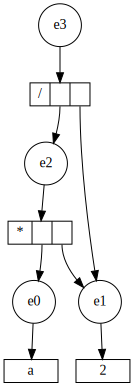

In [ ]:
def _repr_svg_(self):
    def format_record(x):
      if isinstance(x, list):
        return '{' + '|'.join(format_record(e) for e in x) + '}'
      else:
        return x
    def escape(x):
      return str(x).replace('<', '\<').replace('>', '\>')
    g = Digraph(node_attr={'shape': 'record', 'height': '.1'})
    for eclass, enodes in self.eclasses().items():
        g.node(f'{eclass.id}', label=f'e{eclass.id}', shape='circle')

        for enode in enodes:
          enode_id = str(id(enode))
          g.edge(f'{eclass.id}', enode_id)

          record = [escape(enode.key)]
          for i, arg in enumerate(enode.args):
            g.edge(f'{enode_id}:p{i}', f'{arg.id}')
            record.append(f'<p{i}>')
          g.node(enode_id, label='|'.join(record))

    return g._repr_svg_()
EGraph._repr_svg_ = _repr_svg_

eg

We can add other expressions as well, like `a << 1`, which is equivalent to `a * 2`:

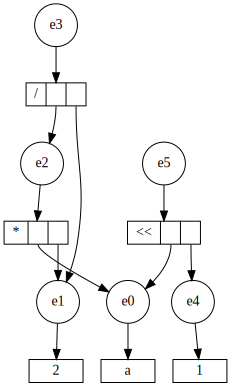

In [ ]:
eg.add_node(exp(lambda a: a << 1))
eg

Merging EClasses
================

Notice that `e2` and `e5` can be merged, since they define the same value. To do this we need to define a the `merge` operation. The details are described in the paper, but you can follow the rest of this document without understanding all the details.

In [ ]:
# tell the graph that 'a' and 'b' calculate the same value.
def merge(self, a: 'EClassID', b: 'EClassID'):
    a = a.find()
    b = b.find()
    if a is b:
        return a
    self.version += 1
    a.parent = b
    # maintain the invariant that uses are only
    # recorded on the top level EClassID
    b.uses += a.uses
    a.uses = None
    # we have updated eclass b, so nodes in the hashcons
    # might no longer be canonical and we might discover that two 
    # enodes are actually the same value. We will repair this later, by
    # remember what eclasses changed:
    self.worklist.append(b)

EGraph.merge = merge

# ensure we have a de-duplicated version of the EGraph
def rebuild(self):
    while self.worklist:
        # deduplicate repeated calls to repair the same eclass
        todo = { eid.find(): None for eid in self.worklist}
        self.worklist = []
        for eclass_id in todo:
            self.repair(eclass_id)
EGraph.rebuild = rebuild


def repair(self, eclass_id: 'ENodeID'):
    assert eclass_id.parent is None
    # reset the uses of this eclass, we will fill them in again at the end
    uses, eclass_id.uses = eclass_id.uses, []
    # any of the uses in the hashcons might no longer be canonical, so re-canonicalize it
    for p_node, p_eclass in uses:
        if p_node in self.hashcons:
            del self.hashcons[p_node]
        p_node = p_node.canonicalize()
        self.hashcons[p_node] = p_eclass.find()
    # because we merged classes, some of the enodes that are uses might now be the same expression,
    # meaning we can merge further eclasses
    new_uses = {}
    for p_node, p_eclass in uses:
        p_node = p_node.canonicalize()
        if p_node in new_uses:
            self.merge(p_eclass, new_uses[p_node])
        new_uses[p_node] = p_eclass.find()
    # note the find, it is possible that eclass_id got merged
    # and uses should only be attributed to the eclass representative
    eclass_id.find().uses += new_uses.items()
EGraph.repair = repair

We can try it out by merging our nodes and observering that `e5` now has two definitions.

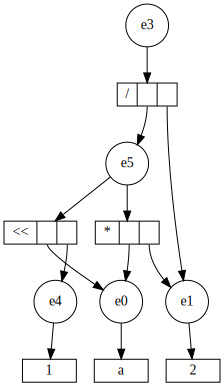

In [ ]:
# lookup the eclasses for these nodes
x_times_2 = eg.add_node(exp(lambda a: a * 2))
x_shift_1 = eg.add_node(exp(lambda a: a << 1))
# and merge them
eg.merge(x_times_2, x_shift_1)
eg.rebuild()
eg

Building a Substitution Engine
==============================

In this case, we manually identified that two specific eclasses that could be merged, but we would like to apply some generic rewrite rules. Let's use our `Node` class to define some patterns we'd apply automatically:

In [ ]:
class Rule:
    def __init__(self, fn):
      self.lhs, self.rhs = exp(fn)
    def __repr__(self):
        return f"{self.lhs} -> {self.rhs}"
rules = [
    Rule(lambda x: (x * 2, x << 1)), # times is a shift
    Rule(lambda x, y, z: ((x * y) / z, x * (y / z))), # reassociate
    Rule(lambda x: (x / x, Node(1,()))), # simplify
    Rule(lambda x: (x * 1, x)), # simplify
]
rules

[(* x 2) -> (<< x 1),
 (/ (* x y) z) -> (* x (/ y z)),
 (/ x x) -> 1,
 (* x 1) -> x]

Now we define a pattern matching function that takes a pattern, matches it to nodes in the graph, and returns the eclasses that match, along with dictionary mapping the free variables in the pattern to the eclasses they matched to.

In [ ]:
Env = Dict[str, EClassID]
def ematch(eclasses: 'Dict[EClassID, List[ENode]]', pattern: Node) -> 'List[Tuple[EClassID, Env]]':
    def match_in(p: 'Node', eid: 'EClassID', env: Env) -> 'Tuple[Bool, Env]':
        def enode_matches(p: Node, enode: ENode, env: Env) -> 'Tuple[Bool, Env]':
            if enode.key != p.key:
                return False, env
            new_env = env
            for arg_pattern, arg_eid in zip(p.args, enode.args):
                matched, new_env = match_in(arg_pattern, arg_eid, new_env)
                if not matched:
                    return False, env
            return True, new_env
        if not p.args and not isinstance(p.key, int):
            # this is a leaf variable like x, match it with the environment
            id = p.key
            if id not in env:
                env = {**env} # this is expensive but can be optimized
                env[id] = eid
                return True, env
            else:
                # check this value matches to the same thing
                return env[id] is eid, env
        else:
            # does one of the ways to define this class match the pattern?
            for enode in eclasses[eid]:
                matches, new_env = enode_matches(p, enode, env)
                if matches:
                    return True, new_env
            return False, env

    matches = []
    for eid in eclasses.keys():
        match, env = match_in(pattern, eid, {})
        if match:
            matches.append((eid, env))
    return matches

Lets match `(x * y) / z` against the graph:

In [ ]:
matches = ematch(eg.eclasses(), rules[1].lhs)
matches[0]

(e3, {'x': e0, 'y': e1, 'z': e1})

Another useful building block is the ability to create new nodes in the egraph based on a pattern, and an environment to bind the free variables in the pattern to eclasses: 

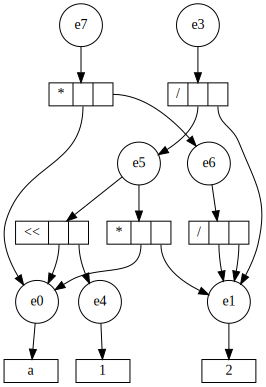

In [ ]:
def subst(self, pattern: Node, env: Env) -> EClassID:
    if not pattern.args and not isinstance(pattern.key, int):
        return env[pattern.key]
    else:
        enode = ENode(pattern.key, tuple(self.subst(arg, env) for arg in pattern.args))
        return self.add_enode(enode)
EGraph.subst = subst


lhs, env = matches[0]
rhs = eg.subst(rules[1].rhs, env)
eg

We can tell the egraph that this substitution was equivalent to the original pattern match:

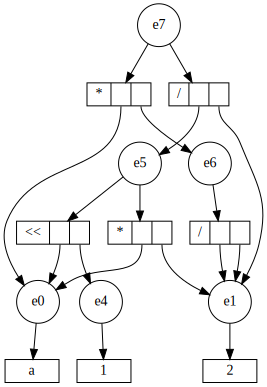

In [ ]:
eg.merge(lhs, rhs)
eg.rebuild()
eg

Substitution Engine Loop
========================

We can put these together into a loop that applies the rewrite rules:

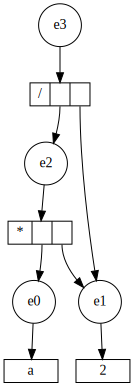

In [ ]:
def apply_rules(eg: 'EGraph', rules: 'List[Rule]'):
    eclasses = eg.eclasses()
    matches = []
    for rule in rules:
        for eid, env in ematch(eclasses, rule.lhs):
            matches.append((rule, eid, env))
    print(f"VERSION {eg.version}")
    for rule, eid, env in matches:
        new_eid = eg.subst(rule.rhs, env)
        if eid is not new_eid:
          print(f'{eid} MATCHED {rule} with {env}')
        eg.merge(eid, new_eid)
    eg.rebuild()
    return eg

eg = EGraph()
eg.add_node(exp(lambda a: (a * 2) / 2))
eg

Now can we apply the rules and see how the rules get applied and the graph changes:

VERSION 4
e2 MATCHED (* x 2) -> (<< x 1) with {'x': e0}
e3 MATCHED (/ (* x y) z) -> (* x (/ y z)) with {'x': e0, 'y': e1, 'z': e1}


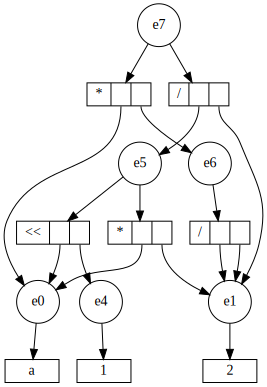

In [ ]:
apply_rules(eg, rules)

VERSION 10
e6 MATCHED (/ x x) -> 1 with {'x': e1}


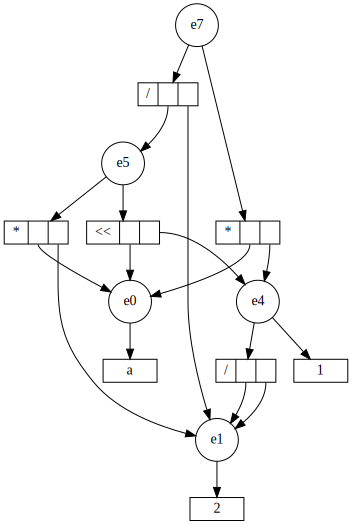

In [ ]:
apply_rules(eg, rules)

VERSION 11
e7 MATCHED (* x 1) -> x with {'x': e0}


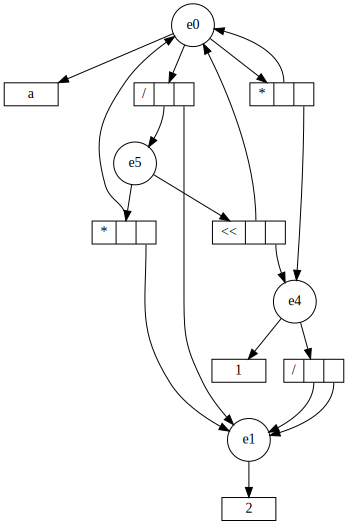

In [ ]:
apply_rules(eg, rules)

Notice how the version counter stops going up now because we have reached a saturated state:

VERSION 12
VERSION 12


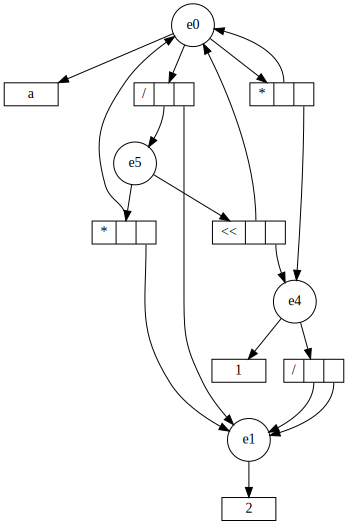

In [ ]:
apply_rules(eg, rules)
apply_rules(eg, rules)

Choosing the Best Options
=========================

Cool, but how do we get a node back out? We have to choose among all the options for each node. There are many ways to do this but here is a simple one that calculates the cost of each node as the cost of its children, plus a fixed amount depending operator. We have to iterate to convergence because there may be cycles in the egraph.

In [ ]:
import math
e_cost = {
    '+': 1,
    '*': 2,
    '/': 3,
    '<<': 1,
}
def schedule(eg: 'EGraph', result: 'EGraphID') -> 'Node':
    result = result.find()
    eclasses = eg.eclasses()
    # set each cost to infinity
    cost = {eclass: (math.inf, None) for eclass in eclasses.keys()} # eclass -> (cost, enode)
    changed = True
    def enode_cost(enode):
        return e_cost.get(enode.key, 0) + sum(cost[eid][0] for eid in enode.args)
    # iterate until we settle, taking the lowest cost option
    while changed:
        changed = False
        for eclass, enodes in eclasses.items():
            new_cost = min((enode_cost(enode), enode) for enode in enodes)
            if cost[eclass][0] != new_cost[0]:
                changed = True
            cost[eclass] = new_cost

    def extract(eid):
        enode = cost[eid][1]
        return Node(enode.key, tuple(extract(a) for a in enode.args))

    return extract(result)


Notice how at each iteration, we find better and better versions:

In [ ]:
eg = EGraph()
r = eg.add_node(exp(lambda a: (a * 2) / 2))

while True:
  version = eg.version
  print('BEST ', schedule(eg, r))
  apply_rules(eg, rules)
  if version == eg.version:
    break

BEST  (/ (* a 2) 2)
VERSION 4
e2 MATCHED (* x 2) -> (<< x 1) with {'x': e0}
e3 MATCHED (/ (* x y) z) -> (* x (/ y z)) with {'x': e0, 'y': e1, 'z': e1}
BEST  (/ (<< a 1) 2)
VERSION 10
e6 MATCHED (/ x x) -> 1 with {'x': e1}
BEST  (* a 1)
VERSION 11
e7 MATCHED (* x 1) -> x with {'x': e0}
BEST  a
VERSION 12


More Info
=========

The paper (https://egraphs-good.github.io) is a pretty easy to follow resource for learning more, and it comes with an efficient Rust implementation.